🚀 Running Scale Benchmark on: ../data/processed/OAI_mega_cohort.parquet
   Cohort Size: 3526

--- Experiment: Clinical Only ---
   Train C-Index: 0.8187
   Test C-Index:  0.7482

--- Experiment: Clinical + Biomarkers ---
   Train C-Index: 0.8135
   Test C-Index:  0.7435
   Calculating Importance...


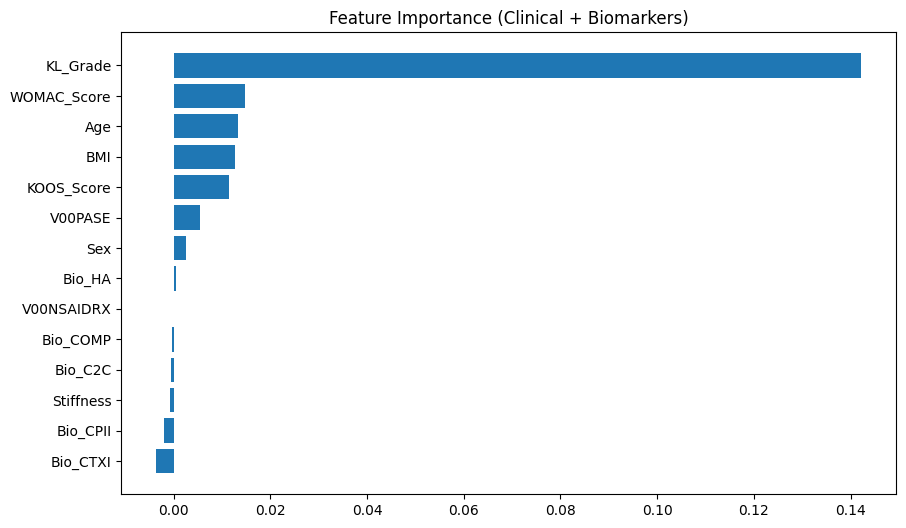


=== FINAL THESIS RESULTS ===
                   Model   C-Index
0          Clinical Only  0.748182
1  Clinical + Biomarkers  0.743490


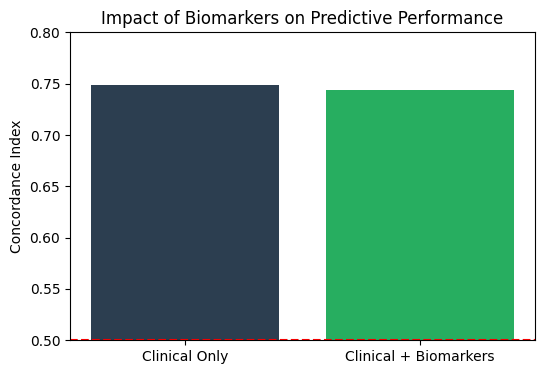

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer

# --- CONFIGURATION ---
# We use the MEGA cohort (3526 patients)
PARQUET_PATH = '../data/processed/OAI_mega_cohort.parquet'

print(f"🚀 Running Scale Benchmark on: {PARQUET_PATH}")

# 1. Load Data
df = pd.read_parquet(PARQUET_PATH)
print(f"   Cohort Size: {len(df)}")

# 2. Define Feature Sets
# We will test incremental value
clinical_feats = ['Age', 'BMI', 'Sex', 'KL_Grade', 'WOMAC_Score', 'KOOS_Score', 'Stiffness', 'V00PASE', 'V00NSAIDRX']
bio_feats = ['Bio_COMP', 'Bio_CTXI', 'Bio_HA', 'Bio_C2C', 'Bio_CPII']
# MRI is mostly imputed zeros in this file, so we exclude it to avoid noise
# mri_feats = ['MRI_BML_Score'] 

# Standardize Sex
if df['Sex'].dtype == 'O':
    df['Sex'] = df['Sex'].map({'Male': 0, 'Female': 1})

# 3. Prepare Target
y = np.zeros(len(df), dtype=[('Status', '?'), ('Survival_in_days', '<f8')])
y['Status'] = df['event'].astype(bool)
y['Survival_in_days'] = df['time_to_event']

# 4. Experiment Loop
experiments = [
    ("Clinical Only", clinical_feats),
    ("Clinical + Biomarkers", clinical_feats + bio_feats)
]

results = []

for name, feats in experiments:
    print(f"\n--- Experiment: {name} ---")
    X = df[feats]
    
    # Impute any remaining NaNs (Robustness)
    imputer = SimpleImputer(strategy='median')
    X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
    
    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train Forest
    # Increased min_samples_leaf to prevent overfitting on noise
    rsf = RandomSurvivalForest(
        n_estimators=1000, 
        min_samples_split=20, 
        min_samples_leaf=20, 
        max_depth=10,
        n_jobs=-1, 
        random_state=42
    )
    rsf.fit(X_train, y_train)
    
    # Evaluate
    train_c = rsf.score(X_train, y_train)
    test_c = rsf.score(X_test, y_test)
    
    print(f"   Train C-Index: {train_c:.4f}")
    print(f"   Test C-Index:  {test_c:.4f}")
    
    results.append({'Model': name, 'C-Index': test_c})

    # Feature Importance (Only for best model)
    if "Biomarkers" in name:
        print("   Calculating Importance...")
        perm_imp = permutation_importance(rsf, X_test, y_test, n_repeats=5, random_state=42, n_jobs=-1)
        
        # Sort and Plot
        sorted_idx = perm_imp.importances_mean.argsort()
        plt.figure(figsize=(10, 6))
        plt.barh(range(len(feats)), perm_imp.importances_mean[sorted_idx], align='center')
        plt.yticks(range(len(feats)), [feats[i] for i in sorted_idx])
        plt.title(f"Feature Importance ({name})")
        plt.show()

# 5. Final Summary
print("\n=== FINAL THESIS RESULTS ===")
res_df = pd.DataFrame(results)
print(res_df)

plt.figure(figsize=(6,4))
plt.bar(res_df['Model'], res_df['C-Index'], color=['#2c3e50', '#27ae60'])
plt.ylim(0.5, 0.8)
plt.ylabel("Concordance Index")
plt.title("Impact of Biomarkers on Predictive Performance")
plt.axhline(0.5, color='red', linestyle='--')
plt.show()

In [2]:
# --- CELL TO ADD AT THE END OF notebook 12 ---
import joblib
import os

# 1. Retrain the best model on ALL data (Train + Test) for the final product
# Best config from your benchmark:
print("Training Final Deployment Model (Clinical + Biomarkers)...")

# Prepare Full X and y
final_features = [
    'Age', 'BMI', 'Sex', 'KL_Grade', 'WOMAC_Score', 
    'KOOS_Score', 'Stiffness', 'V00PASE', 'V00NSAIDRX',
    'Bio_COMP', 'Bio_CTXI', 'Bio_HA', 'Bio_C2C', 'Bio_CPII'
]
X_final = df[final_features].fillna(0) # Safety fill

# 2. Save the Imputer Statistics (Crucial for new patients!)
# We need to save the median values to fill blanks for new users
imputer_stats = X_final.median().to_dict()

# 3. Train
rsf_final = RandomSurvivalForest(
    n_estimators=1000, 
    min_samples_split=20, 
    min_samples_leaf=20, 
    max_depth=10, 
    n_jobs=-1, 
    random_state=42
)
rsf_final.fit(X_final, y)

# 4. Save everything
MODEL_DIR = '../models'
if not os.path.exists(MODEL_DIR): os.makedirs(MODEL_DIR)

joblib.dump(rsf_final, f'{MODEL_DIR}/random_forest_survival.joblib')
joblib.dump(imputer_stats, f'{MODEL_DIR}/imputer_stats.joblib')

print(f"✅ Model Saved to {MODEL_DIR}/random_forest_survival.joblib")
print(f"✅ Imputer Stats Saved.")

Training Final Deployment Model (Clinical + Biomarkers)...
✅ Model Saved to ../models/random_forest_survival.joblib
✅ Imputer Stats Saved.
